In [43]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [44]:
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow.keras.utils as utils
import os

In [73]:
#http://web.mit.edu/music21/doc/usersGuide/usersGuide_08_installingMusicXML.html
import music21

In [45]:
np.random.seed(5) # 시드 고정

## 1. 데이터 준비하기

### 시퀀스 데이터 정의

In [48]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

print("length of seq: {0}".format(len(seq)))

length of seq: 54


In [74]:
note_seq = ""
for note in seq:
    note_seq += note + " "
    
m = music21.converter.parse("2/4 " + note_seq, format='tinyNotation')

m.show("midi")

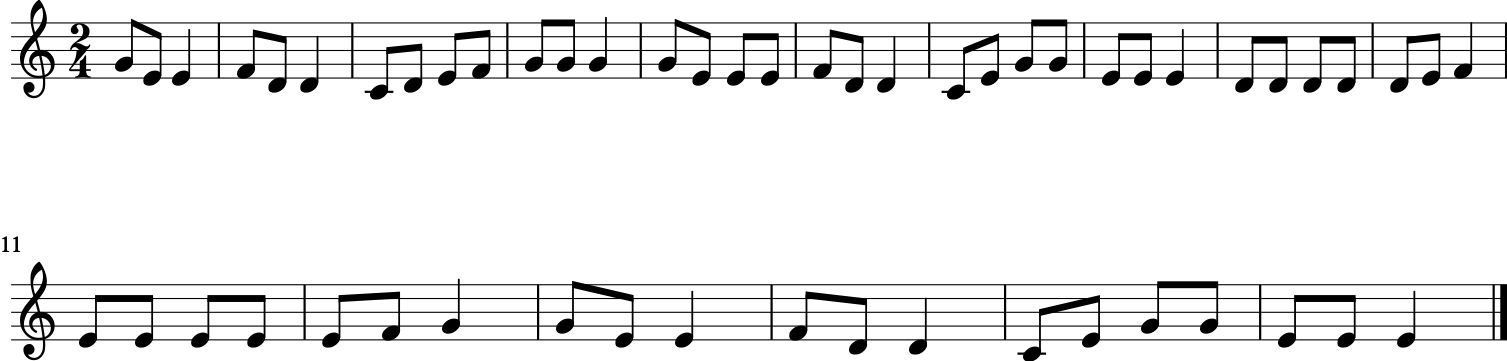

In [72]:
m.show()

### 코드 사전 정의

In [46]:
code2idx = {'c4': 0, 'd4': 1, 'e4': 2, 'f4': 3, 'g4': 4, 'a4': 5, 'b4': 6,
            'c8': 7, 'd8': 8, 'e8': 9, 'f8': 10, 'g8': 11, 'a8': 12, 'b8': 13}

idx2code = {0: 'c4', 1: 'd4', 2: 'e4', 3: 'f4', 4: 'g4', 5: 'a4', 6: 'b4',
            7: 'c8', 8: 'd8', 9: 'e8', 10: 'f8', 11: 'g8', 12: 'a8', 13: 'b8'}

In [47]:
code2scale = {'c': 0, 'd': 1, 'e': 2, 'f': 3, 'g': 4, 'a': 5, 'b': 6}

code2length = {'4': 0, '8': 1}

## 2. 데이터셋 생성하기

### 데이터셋 생성 함수


In [49]:
def seq2dataset(seq, window_size):
    dataset_X = []
    dataset_Y = []

    for i in range(len(seq) - window_size):
        subset = seq[i:(i + window_size + 1)]

        for si in range(len(subset) - 1):
            features = code2features(subset[si])
            dataset_X.append(features)

        dataset_Y.append([code2idx[subset[window_size]]])

    return np.array(dataset_X), np.array(dataset_Y)

### 속성 변환 함수

In [50]:
max_scale_value = len(code2scale) - 1

def code2features(code):
    features = []
    features.append(code2scale[code[0]] / float(max_scale_value))
    features.append(code2length[code[1]])
    return features

###  생성

In [51]:
n_steps = 4
n_inputs = 2

x_train, y_train = seq2dataset(seq, window_size=n_steps)
print("x_train: {0}".format(x_train.shape))
print("y_train: {0}".format(y_train.shape))

x_train: (200, 2)
y_train: (50, 1)


### 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환

In [52]:
# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, n_steps, n_inputs))

### 라벨값에 대한 one-hot 인코딩 수행

In [53]:
y_train = utils.to_categorical(y_train)
one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)
print("After pre-processing")
print("x_train: {0}".format(x_train.shape))
print("y_train: {0}".format(y_train.shape))

one hot encoding vector size is  12
After pre-processing
x_train: (50, 4, 2)
y_train: (50, 12)


## 3. 모델 구성하기

In [105]:
model = Sequential()
model.add(LSTM(
    units=128,
    kernel_initializer='glorot_normal',
    bias_initializer='zero',
    batch_input_shape=(1, n_steps, n_inputs), 
    stateful=True
))
model.add(Dense(
    units=one_hot_vec_size, 
    kernel_initializer='glorot_normal',
    bias_initializer='zero',    
    activation='softmax'
))

## 4. 모델 학습과정 설정하기

In [106]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## 5. 모델 학습시키기

### 손실 이력 클래스 정의

In [107]:
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
        if self.epoch % 100 == 0:
            print("epoch: {0} - loss: {1:8.6f}".format(self.epoch, logs.get('loss')))
            
        self.epoch += 1            

### 학습

In [108]:
num_epochs = 1500
history = LossHistory()  # 손실 이력 객체 생성

history.init()

for epoch_idx in range(num_epochs + 1):
    model.fit(
        x=x_train,
        y=y_train,
        epochs=1,
        batch_size=1,
        verbose=0,
        shuffle=False,
        callbacks=[history]
    )
    if history.losses[-1] < 1e-5:
        print("epoch: {0} - loss: {1:8.6f}".format(epoch_idx, history.losses[-1]))
        model.reset_states()    
        break    
    model.reset_states()

epoch: 0 - loss: 2.320404
epoch: 100 - loss: 0.308659
epoch: 200 - loss: 0.000465
epoch: 300 - loss: 0.797417
epoch: 400 - loss: 0.000614
epoch: 500 - loss: 0.000030
epoch: 541 - loss: 0.000010


## 6. 학습과정 살펴보기

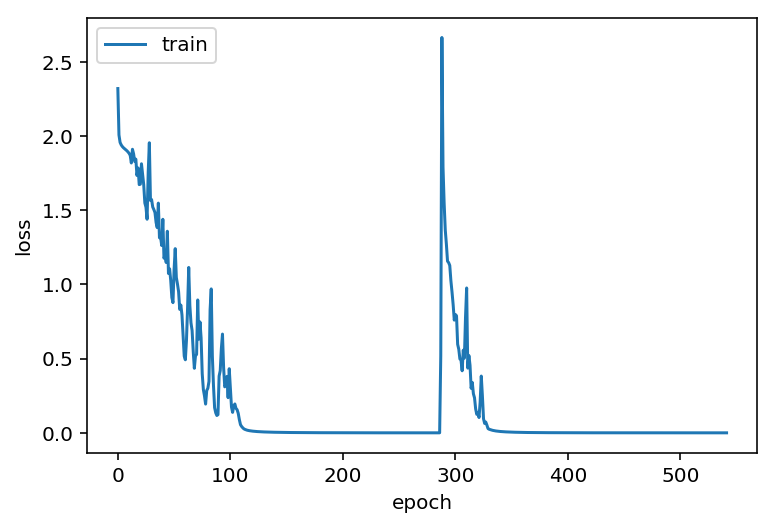

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## 7. 모델 평가하기

In [110]:
scores = model.evaluate(x_train, y_train, batch_size=1)
print("{0}: {1}".format(model.metrics_names[1], scores[1]*100))
model.reset_states()

50/50 [==============================] - 0s 3ms/sample - loss: 9.8323e-06 - accuracy: 1.0000
accuracy: 100.0


## 8. 모델 사용하기

### 한 스텝 예측

In [111]:
pred_count = 50  # 최대 예측 개수 정의

# 한 스텝 예측
seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i])  # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx])  # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

model.reset_states()

print("one step prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


### 곡 전체 예측

In [116]:
#seq_in = ['g8', 'e8', 'e4', 'f8']
seq_in = ['f8', 'c8', 'd8', 'e4']
seq_out = seq_in

seq_in_featrues = []

for si in seq_in:
    features = code2features(si)
    seq_in_featrues.append(features)

for i in range(pred_count):
    sample_in = np.array(seq_in_featrues)
    sample_in = np.reshape(sample_in, (1, n_steps, n_inputs))  # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])

    features = code2features(idx2code[idx])
    seq_in_featrues.append(features)
    seq_in_featrues.pop(0)

model.reset_states()
    
print("full song prediction: ", seq_out)

full song prediction:  ['f8', 'c8', 'd8', 'e4', 'd8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8']


In [119]:
note_seq = ""
for note in seq_out:
    note_seq += note + " "
    
m = music21.converter.parse("2/4 " + note_seq, format='tinyNotation')

m.show("midi")

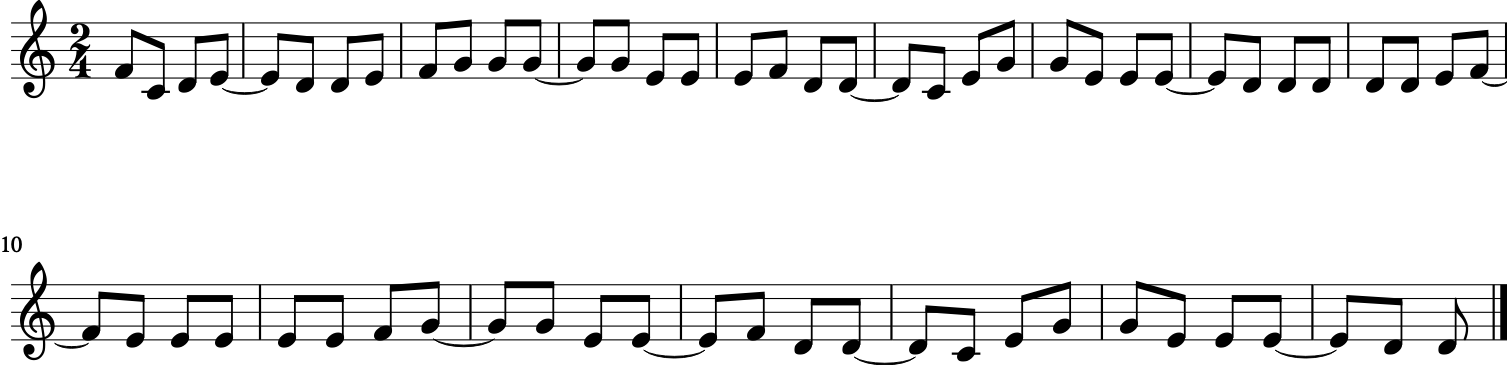

In [120]:
m.show()

In [115]:
m.write("midi", fp="./new_music_2.mid")

'./new_music_2.mid'